In [1]:
#导入相关包
import numpy as np
import torch as t
import random
import matplotlib.pyplot as plt
#import netCDF4
import datetime
import torch
from tqdm import tqdm
from torch import nn
from torch import optim
from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.autograd as autograd
import torch.nn.functional as F
from einops import rearrange, repeat
import os
#from config import args
#import seaborn as sns
#from global_land_mask import globe
#from scipy import interpolate
#plt.rcParams['font.sans-serif'] = ['SimHei'] #中文支持
%matplotlib inline

/mnt/miniconda3/envs/MJO_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 固定随机种子
SEED = 22

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(SEED)

In [3]:
path='/WdHeDisk/users/zhangnong/MJO/908_test/data/s2s_dataset_for5_5_35/'
wei = '_for5_5_35_sample.npy'

In [4]:
X_train=np.load(path+'X_train'+wei)
Y_train=np.load(path+'Y_train'+wei)
X_valid=np.load(path+'X_valid'+wei)
Y_valid=np.load(path+'Y_valid'+wei)
X_test=np.load(path+'X_test'+wei)
Y_test=np.load(path+'Y_test'+wei)

In [5]:
print(X_train.shape,Y_train.shape)
print(X_valid.shape,Y_valid.shape)

(9200, 5, 13, 144, 4) (9200, 35, 2)
(400, 5, 13, 144, 4) (400, 35, 2)


In [6]:
# 构造数据管道
class MJODataset(Dataset):
    def __init__(self, data,label):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.label = torch.tensor(label, dtype=torch.float32)

    def __len__(self):
        return len(self.label)
    
    def __getitem__(self, idx):
        return self.data[idx],self.label[idx]
batch_size = 16
#刚刚 batchsize = 32 还不错15～16天，lr = 1e-3， deacy = 0.001 ，数据集是22800， 1600， 1600， 模型三层4096， 1024， 90
#无dropout
trainset = MJODataset(X_train, Y_train)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

validset = MJODataset(X_valid, Y_valid)
validloader = DataLoader(validset, batch_size=batch_size, shuffle=True)

testset = MJODataset(X_test, Y_test)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)
print(len(trainloader))

575


In [7]:
if torch.cuda.is_available():
    device=torch.device("cuda:1")
else :
    device=torch.device("cpu")

In [8]:
#cnn模块
# 构建CNN单元
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super().__init__()
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        if (in_channels == out_channels) and (stride == 1):
            self.res = lambda x: x
        else:
            self.res = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride)
        
    def forward(self, x):
        # 残差
        res = self.res(x)
        res = self.bn2(res)

        x = F.relu(self.bn1(x))
        x = self.conv(x)
        x = self.bn2(x)
        
        x = x + res
        
        return x

In [9]:
#编码
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_directions = 1
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=False)


    def forward(self, x):
        
        batch_size, T, C = x.shape
        
        h = torch.randn(self.num_directions * self.num_layers, batch_size, self.hidden_size).to(device)
        c = torch.randn(self.num_directions * self.num_layers, batch_size, self.hidden_size).to(device)

        
        #lstm训练
        output, (h, c) = self.lstm(x, (h, c))
        #output[batch_size, time_squence, hidden_size]
        #h[2, batch_size, hidden_size]

        return   h, c

In [10]:
#解码
class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        #outsize = 45
        self.num_directions = 1  
        
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, self.num_layers, batch_first=True, bidirectional=False)
        
        self.fc1 = nn.Linear(self.hidden_size, self.output_size)
        self.fc2 = nn.Linear(self.hidden_size, self.output_size)
        

    def forward(self, x, h, c):
        # x = [batchsize, input_size]
        batch_size = x.shape[0]
        x = x.view(batch_size, 1, self.input_size)
        
        output, (h, c) = self.lstm(x, (h, c))
        
        # output(batch_size, seq_len, num * hidden_size)
        rmm1 = self.fc1(output)  # pred(batch_size, 1, output_size)
        rmm2 = self.fc2(output)
        
        rmm1 = rmm1[:, -1, :]
        rmm2 = rmm2[:, -1, :]

        return rmm1, rmm2, h, c



In [11]:
#定义模型
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_size = 576
        self.output_size = 35
        self.hidden_size = 1024
        self.num_layers = 1
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=7, stride=2, padding=3)
        self.conv2=CNNBlock(16, 16, 3, 1, 1)
        self.conv3=CNNBlock(16, 32, 3, 2, 1)
        self.conv4=CNNBlock(32, 32, 3, 1, 1)
        self.conv5=CNNBlock(32, 64, 3, 2, 1)
        self.conv6=CNNBlock(64, 64, 3, 1, 1)

        
        self.avgpool = nn.AdaptiveAvgPool2d((3, 3))#(16,4,69)
        self.flatten = nn.Flatten()
        
        self.Encoder = Encoder(self.input_size, self.hidden_size, self.num_layers)
        self.Decoder = Decoder(self.input_size, self.hidden_size, self.num_layers, self.output_size)

    def forward(self, x):
        
        x = x[:, :, :, :, 0:3]
        batch_size, seq_len, H, W, C = x.shape
        x = x.permute(0, 1, 4, 2, 3).contiguous()
        x = x.view(batch_size * seq_len, C, H, W)
        
        #cnn部分
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)

        
        x = self.avgpool(x)
        x = self.flatten(x)
        
        _, C_new = x.shape
        
        x = x.view(batch_size, seq_len, C_new)
        
        
        
        h, c = self.Encoder(x)
        
        outputs_rmm1 = torch.zeros(batch_size, seq_len, self.output_size).to(device)
        outputs_rmm2 = torch.zeros(batch_size, seq_len, self.output_size).to(device)
        
        for t in range(seq_len):
            _input = x[:, t, :]
            
            output1, output2, h, c = self.Decoder(_input, h, c)
            
            outputs_rmm1[:, t, :] = output1
            outputs_rmm2[:, t, :] = output2
        
        rmm1 = outputs_rmm1[:, -1, :]
        rmm2 = outputs_rmm2[:, -1, :]
        
        rmm1 = rmm1.squeeze()
        rmm2 = rmm2.squeeze()
        
        rmm1 = rmm1.unsqueeze(2)
        rmm2 = rmm2.unsqueeze(2)

        RMM = torch.cat((rmm1, rmm2), dim = 2)
        
        return RMM



In [12]:
model = Model()
print(model)

Model(
  (conv1): Conv2d(3, 16, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (conv2): CNNBlock(
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): CNNBlock(
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (res): Conv2d(16, 32, kernel_size=(1, 1), stride=(2, 2))
  )
  (conv4): CNNBlock(
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
 

In [13]:
#cor函数
def cor(Y_test,t_preds):
    #Y_test = mean_std(Y_test)
    #t_preds = mean_std(t_preds)
    cor_day = []
    a=0
    b=0
    c=0
    score_cor=0
    for i in range(0,35):
        for j in range(0,len(Y_test)):
            a+=(Y_test[j,i,:]*t_preds[j,i,:]).sum()
            b+=(Y_test[j,i]**2).sum()
            c+=(t_preds[j,i]**2).sum()
        b=np.sqrt(b)
        c=np.sqrt(c)
        cor=a/(b*c)
        cor_day.append(cor)
        a=0
        b=0
        c=0
    cor_day=np.array(cor_day)
    #print(cor_day)
    for i in range(0,len(cor_day)):
        if cor_day[i]<0.50:
            break
    score_cor=i
    return score_cor

def rmse_new(Y_valid,preds):
    #Y_valid = mean_std(Y_valid)
    #preds = mean_std(preds)
    rmse_day = []
    a=0
    score_rmse=0
    for i in range(0,35):
        for j in range(0,len(Y_valid)):
            a+=(torch.pow((Y_valid[j,i,:]-preds[j,i,:]),2)).sum()
        rmse=a/len(Y_valid)
        rmse=np.sqrt(rmse)
        rmse_day.append(rmse)
        a=0
    rmse_day=np.array(rmse_day)
    #print(rmse_day)
    for i in range(0,len(rmse_day)):
        if rmse_day[i]>1.40:
            break
    score_rmse=i
    '''
    day_cal=np.argwhere(rmse_day<1.40)
    print(day_cal)
    if len(day_cal)==0:
        score_rmse=0
    else:
        score_rmse=day_cal.max()+1
    '''
    #score_rmse=rmse_day.max()
    return score_rmse

def rmse_max(Y_valid,preds):
    #Y_valid = mean_std(Y_valid)
    #preds = mean_std(preds)
    rmse_day = []
    a=0
    score_rmse=0
    for i in range(0,35):
        for j in range(0,len(Y_valid)):
            a+=(torch.pow((Y_valid[j,i,:]-preds[j,i,:]),2)).sum()
        rmse=a/len(Y_valid)
        rmse=np.sqrt(rmse)
        rmse_day.append(rmse)
        a=0
    rmse_day=np.array(rmse_day)
    score_rmse=rmse_day.max()
    return score_rmse

In [14]:
#自定义损失函数
class My_MSELoss(nn.Module):
    def __init__(self):
        super(My_MSELoss, self).__init__()
        self.mseloss = nn.MSELoss(reduction='mean')

    def forward(self, pred, label):
        loss1 = self.mseloss(pred[:,:,0], label[:,:,0])
        loss2 = self.mseloss(pred[:,:,1], label[:,:,1])
        
        loss = (loss1 +loss2)/2

        return loss




In [15]:
#设置参数
model_weights = '/WdHeDisk/users/zhangnong/MJO/908_test/cnn_seq2seq_s2s_data_weights.pth'

model = Model().to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.001)  # weight_decay是L2正则化参数

epochs = 40

#criterion = My_MSELoss()
criterion = nn.MSELoss()

In [16]:
train_losses, valid_losses = [], []
scores_rmse = []
#scores_cor = []
best_score1 = float('-inf')
best_score2 = float('inf')
preds = np.zeros((len(Y_valid),35,2))
y_valid=np.zeros((len(Y_valid),35,2))
#Y_valid=t.from_numpy(Y_valid)
print(preds.shape)

(400, 35, 2)


In [17]:
#模型训练
for epoch in range(epochs):
    print('Epoch: {}/{}'.format(epoch+1, epochs))
    model.train()
    losses = 0
    for data1, labels in tqdm(trainloader):
        data1 = data1.to(device)
        labels = labels.to(device)
        model.zero_grad()
        #optimizer.zero_grad()
        pred = model(data1)
        #print('pred.size:',pred.size())
        #pred= pred.permute(0,2,1).contiguous()
        loss = criterion(pred, labels)
        losses += loss.cpu().detach().numpy()
        #print(pred.dtype)
        #print(labels.dtype)
        #print(loss.dtype)
        loss.backward()
        optimizer.step()
        #scheduler.step()
    train_loss = losses / len(trainloader)
    train_losses.append(train_loss)
    print('Training Loss: {:.3f}'.format(train_loss))
# 模型验证
    model.eval()
    losses = 0
    s=0
    ss=0
    s_rmse=0
    with torch.no_grad():
        for i, data in tqdm(enumerate(validloader)):
            data1, labels = data
            data1 = data1.to(device)
            y_valid[i*batch_size:(i+1)*batch_size]=labels.detach().cpu()
            labels = labels.to(device)
            pred = model(data1)

            #pred= pred.permute(0,2,1).contiguous()
            loss = criterion(pred, labels)
            #print('loss:',loss)
            losses += loss.cpu().detach().numpy()
            preds[i*batch_size:(i+1)*batch_size] = pred.detach().cpu()
        valid_loss = losses / len(validloader)
        valid_losses.append(valid_loss)
        print('Validation Loss: {:.3f}'.format(valid_loss))
    #print(len(valid_losses))
        preds=torch.as_tensor(preds)
        y_valid=torch.as_tensor(y_valid)
    #print(preds.dtype,Y_valid.dtype)
    #print(len(preds))
    #print(len(preds[1]))
        s=rmse_new(y_valid,preds)
    #s=rmse(Y_valid,preds)
    #s=rmse_caluate(Y_valid,preds)
        ss=cor(y_valid,preds)
        s_rmse=rmse_max(y_valid,preds)
    #s.item()
    #print(s)
    #s=score_rmse(Y_valid,preds)
        scores_rmse.append(s)
    #scores_cor.append(ss)
        print('day_rmse: {:}'.format(s))
        print('day_cor: {:}'.format(ss))
        print('rmse_max: {:.3f}'.format(s_rmse))
    #print('Score_cor: {:.3f}'.format(ss))
# 保存最佳模型权重
    #s=s.numpy()
    #ss=ss.numpy()
    #fina_score=score(s,ss)
    #print(s.type)
    #print(ss.type)
    final_s=min(s,ss)
    if (final_s > best_score1) :
        best_score1 = final_s
        best_score2 = s_rmse
        #best_score2 = ss
        checkpoint = {'best_score': best_score1,'state_dict': model.state_dict()}
        torch.save(checkpoint, model_weights)
    if (final_s==best_score1)&(s_rmse < best_score2):
        best_score1 = final_s
        best_score2 = s_rmse
        #best_score2 = ss
        checkpoint = {'best_score': best_score1,'state_dict': model.state_dict()}
        torch.save(checkpoint, model_weights) 
    print('best_day:{:}'.format(best_score1))
    print('best_rmse:{:.3f}'.format(best_score2))
    #scheduler.step()

Epoch: 1/40


100%|█████████████████████████████████████████| 575/575 [00:24<00:00, 23.65it/s]


Training Loss: 0.258


25it [00:00, 80.23it/s]


Validation Loss: 0.225
day_rmse: 34
day_cor: 18
rmse_max: 0.751
best_day:18
best_rmse:0.751
Epoch: 2/40


100%|█████████████████████████████████████████| 575/575 [00:20<00:00, 28.75it/s]


Training Loss: 0.211


25it [00:00, 93.86it/s]


Validation Loss: 0.213
day_rmse: 34
day_cor: 20
rmse_max: 0.723
best_day:20
best_rmse:0.723
Epoch: 3/40


100%|█████████████████████████████████████████| 575/575 [00:19<00:00, 28.76it/s]


Training Loss: 0.189


25it [00:00, 95.50it/s]


Validation Loss: 0.214
day_rmse: 34
day_cor: 19
rmse_max: 0.725
best_day:20
best_rmse:0.723
Epoch: 4/40


100%|█████████████████████████████████████████| 575/575 [00:19<00:00, 28.87it/s]


Training Loss: 0.172


25it [00:00, 95.28it/s]


Validation Loss: 0.211
day_rmse: 34
day_cor: 23
rmse_max: 0.731
best_day:23
best_rmse:0.731
Epoch: 5/40


100%|█████████████████████████████████████████| 575/575 [00:20<00:00, 28.41it/s]


Training Loss: 0.159


25it [00:00, 95.25it/s]


Validation Loss: 0.198
day_rmse: 34
day_cor: 26
rmse_max: 0.692
best_day:26
best_rmse:0.692
Epoch: 6/40


100%|█████████████████████████████████████████| 575/575 [00:18<00:00, 31.22it/s]


Training Loss: 0.148


25it [00:00, 95.38it/s]


Validation Loss: 0.206
day_rmse: 34
day_cor: 24
rmse_max: 0.712
best_day:26
best_rmse:0.692
Epoch: 7/40


100%|█████████████████████████████████████████| 575/575 [00:19<00:00, 28.91it/s]


Training Loss: 0.140


25it [00:00, 93.86it/s]


Validation Loss: 0.208
day_rmse: 34
day_cor: 24
rmse_max: 0.720
best_day:26
best_rmse:0.692
Epoch: 8/40


100%|█████████████████████████████████████████| 575/575 [00:19<00:00, 29.36it/s]


Training Loss: 0.132


25it [00:00, 95.34it/s]


Validation Loss: 0.203
day_rmse: 34
day_cor: 25
rmse_max: 0.710
best_day:26
best_rmse:0.692
Epoch: 9/40


100%|█████████████████████████████████████████| 575/575 [00:19<00:00, 29.05it/s]


Training Loss: 0.126


25it [00:00, 95.32it/s]


Validation Loss: 0.203
day_rmse: 34
day_cor: 32
rmse_max: 0.717
best_day:32
best_rmse:0.717
Epoch: 10/40


100%|█████████████████████████████████████████| 575/575 [00:19<00:00, 28.81it/s]


Training Loss: 0.121


25it [00:00, 94.77it/s]


Validation Loss: 0.203
day_rmse: 34
day_cor: 25
rmse_max: 0.707
best_day:32
best_rmse:0.717
Epoch: 11/40


100%|█████████████████████████████████████████| 575/575 [00:20<00:00, 28.23it/s]


Training Loss: 0.117


25it [00:00, 95.22it/s]


Validation Loss: 0.196
day_rmse: 34
day_cor: 33
rmse_max: 0.701
best_day:33
best_rmse:0.701
Epoch: 12/40


100%|█████████████████████████████████████████| 575/575 [00:19<00:00, 29.35it/s]


Training Loss: 0.111


25it [00:00, 94.48it/s]


Validation Loss: 0.192
day_rmse: 34
day_cor: 34
rmse_max: 0.710
best_day:34
best_rmse:0.710
Epoch: 13/40


100%|█████████████████████████████████████████| 575/575 [00:19<00:00, 28.90it/s]


Training Loss: 0.107


25it [00:00, 94.74it/s]


Validation Loss: 0.188
day_rmse: 34
day_cor: 34
rmse_max: 0.682
best_day:34
best_rmse:0.682
Epoch: 14/40


100%|█████████████████████████████████████████| 575/575 [00:20<00:00, 28.13it/s]


Training Loss: 0.103


25it [00:00, 96.59it/s]


Validation Loss: 0.183
day_rmse: 34
day_cor: 34
rmse_max: 0.685
best_day:34
best_rmse:0.682
Epoch: 15/40


100%|█████████████████████████████████████████| 575/575 [00:19<00:00, 29.02it/s]


Training Loss: 0.100


25it [00:00, 95.14it/s]


Validation Loss: 0.175
day_rmse: 34
day_cor: 34
rmse_max: 0.668
best_day:34
best_rmse:0.668
Epoch: 16/40


100%|█████████████████████████████████████████| 575/575 [00:20<00:00, 28.31it/s]


Training Loss: 0.097


25it [00:00, 93.76it/s]


Validation Loss: 0.170
day_rmse: 34
day_cor: 34
rmse_max: 0.655
best_day:34
best_rmse:0.655
Epoch: 17/40


100%|█████████████████████████████████████████| 575/575 [00:20<00:00, 27.76it/s]


Training Loss: 0.095


25it [00:00, 95.17it/s]


Validation Loss: 0.161
day_rmse: 34
day_cor: 34
rmse_max: 0.640
best_day:34
best_rmse:0.640
Epoch: 18/40


100%|█████████████████████████████████████████| 575/575 [00:20<00:00, 27.76it/s]


Training Loss: 0.092


25it [00:00, 95.97it/s]


Validation Loss: 0.172
day_rmse: 34
day_cor: 34
rmse_max: 0.670
best_day:34
best_rmse:0.640
Epoch: 19/40


100%|█████████████████████████████████████████| 575/575 [00:20<00:00, 27.79it/s]


Training Loss: 0.090


25it [00:00, 99.11it/s]


Validation Loss: 0.191
day_rmse: 34
day_cor: 34
rmse_max: 0.691
best_day:34
best_rmse:0.640
Epoch: 20/40


100%|█████████████████████████████████████████| 575/575 [00:20<00:00, 27.74it/s]


Training Loss: 0.087


25it [00:00, 95.15it/s]


Validation Loss: 0.235
day_rmse: 34
day_cor: 34
rmse_max: 0.751
best_day:34
best_rmse:0.640
Epoch: 21/40


100%|█████████████████████████████████████████| 575/575 [00:20<00:00, 27.73it/s]


Training Loss: 0.085


25it [00:00, 96.44it/s]


Validation Loss: 0.273
day_rmse: 34
day_cor: 31
rmse_max: 0.835
best_day:34
best_rmse:0.640
Epoch: 22/40


100%|█████████████████████████████████████████| 575/575 [00:20<00:00, 27.75it/s]


Training Loss: 0.083


25it [00:00, 98.00it/s]


Validation Loss: 0.321
day_rmse: 34
day_cor: 11
rmse_max: 0.921
best_day:34
best_rmse:0.640
Epoch: 23/40


100%|█████████████████████████████████████████| 575/575 [00:20<00:00, 27.75it/s]


Training Loss: 0.081


25it [00:00, 95.31it/s]


Validation Loss: 0.303
day_rmse: 34
day_cor: 15
rmse_max: 0.902
best_day:34
best_rmse:0.640
Epoch: 24/40


100%|█████████████████████████████████████████| 575/575 [00:20<00:00, 27.74it/s]


Training Loss: 0.080


25it [00:00, 93.36it/s]


Validation Loss: 0.330
day_rmse: 34
day_cor: 11
rmse_max: 0.949
best_day:34
best_rmse:0.640
Epoch: 25/40


100%|█████████████████████████████████████████| 575/575 [00:21<00:00, 27.22it/s]


Training Loss: 0.078


25it [00:00, 98.63it/s] 


Validation Loss: 0.329
day_rmse: 34
day_cor: 14
rmse_max: 0.937
best_day:34
best_rmse:0.640
Epoch: 26/40


100%|█████████████████████████████████████████| 575/575 [00:20<00:00, 27.93it/s]


Training Loss: 0.077


25it [00:00, 95.39it/s]


Validation Loss: 0.353
day_rmse: 34
day_cor: 9
rmse_max: 0.979
best_day:34
best_rmse:0.640
Epoch: 27/40


100%|█████████████████████████████████████████| 575/575 [00:19<00:00, 28.98it/s]


Training Loss: 0.076


25it [00:00, 94.52it/s]


Validation Loss: 0.324
day_rmse: 34
day_cor: 11
rmse_max: 0.928
best_day:34
best_rmse:0.640
Epoch: 28/40


100%|█████████████████████████████████████████| 575/575 [00:19<00:00, 28.82it/s]


Training Loss: 0.074


25it [00:00, 97.80it/s]


Validation Loss: 0.371
day_rmse: 34
day_cor: 6
rmse_max: 1.029
best_day:34
best_rmse:0.640
Epoch: 29/40


100%|█████████████████████████████████████████| 575/575 [00:20<00:00, 28.39it/s]


Training Loss: 0.073


25it [00:00, 95.66it/s]


Validation Loss: 0.368
day_rmse: 34
day_cor: 7
rmse_max: 0.996
best_day:34
best_rmse:0.640
Epoch: 30/40


100%|█████████████████████████████████████████| 575/575 [00:19<00:00, 29.02it/s]


Training Loss: 0.072


25it [00:00, 94.58it/s]


Validation Loss: 0.352
day_rmse: 34
day_cor: 6
rmse_max: 0.996
best_day:34
best_rmse:0.640
Epoch: 31/40


100%|█████████████████████████████████████████| 575/575 [00:19<00:00, 28.85it/s]


Training Loss: 0.071


25it [00:00, 96.53it/s]


Validation Loss: 0.382
day_rmse: 34
day_cor: 5
rmse_max: 1.035
best_day:34
best_rmse:0.640
Epoch: 32/40


100%|█████████████████████████████████████████| 575/575 [00:18<00:00, 30.48it/s]


Training Loss: 0.071


25it [00:00, 132.44it/s]


Validation Loss: 0.366
day_rmse: 34
day_cor: 5
rmse_max: 1.015
best_day:34
best_rmse:0.640
Epoch: 33/40


100%|█████████████████████████████████████████| 575/575 [00:19<00:00, 29.04it/s]


Training Loss: 0.069


25it [00:00, 95.37it/s]


Validation Loss: 0.361
day_rmse: 34
day_cor: 6
rmse_max: 0.997
best_day:34
best_rmse:0.640
Epoch: 34/40


100%|█████████████████████████████████████████| 575/575 [00:20<00:00, 28.42it/s]


Training Loss: 0.068


25it [00:00, 110.90it/s]


Validation Loss: 0.378
day_rmse: 34
day_cor: 6
rmse_max: 1.018
best_day:34
best_rmse:0.640
Epoch: 35/40


100%|█████████████████████████████████████████| 575/575 [00:20<00:00, 27.75it/s]


Training Loss: 0.068


25it [00:00, 95.20it/s]


Validation Loss: 0.415
day_rmse: 34
day_cor: 6
rmse_max: 1.071
best_day:34
best_rmse:0.640
Epoch: 36/40


100%|█████████████████████████████████████████| 575/575 [00:20<00:00, 27.75it/s]


Training Loss: 0.067


25it [00:00, 109.83it/s]


Validation Loss: 0.375
day_rmse: 34
day_cor: 6
rmse_max: 0.996
best_day:34
best_rmse:0.640
Epoch: 37/40


100%|█████████████████████████████████████████| 575/575 [00:20<00:00, 27.73it/s]


Training Loss: 0.066


25it [00:00, 100.11it/s]


Validation Loss: 0.386
day_rmse: 34
day_cor: 5
rmse_max: 1.058
best_day:34
best_rmse:0.640
Epoch: 38/40


100%|█████████████████████████████████████████| 575/575 [00:20<00:00, 27.76it/s]


Training Loss: 0.066


25it [00:00, 94.48it/s]


Validation Loss: 0.394
day_rmse: 34
day_cor: 5
rmse_max: 1.055
best_day:34
best_rmse:0.640
Epoch: 39/40


100%|█████████████████████████████████████████| 575/575 [00:20<00:00, 27.76it/s]


Training Loss: 0.065


25it [00:00, 94.98it/s]


Validation Loss: 0.403
day_rmse: 34
day_cor: 4
rmse_max: 1.070
best_day:34
best_rmse:0.640
Epoch: 40/40


100%|█████████████████████████████████████████| 575/575 [00:20<00:00, 27.79it/s]


Training Loss: 0.064


25it [00:00, 99.11it/s]


Validation Loss: 0.376
day_rmse: 34
day_cor: 4
rmse_max: 1.034
best_day:34
best_rmse:0.640


In [18]:
# 绘制训练/验证曲线
def training_vis(train_losses, valid_losses):
    # 绘制损失函数曲线
    fig = plt.figure(figsize=(8,4))
    # subplot loss
    ax1 = fig.add_subplot(121)
    ax1.plot(train_losses, label='train_loss')
    ax1.plot(valid_losses,label='val_loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss on Training and Validation Data')
    ax1.legend()
    plt.tight_layout()

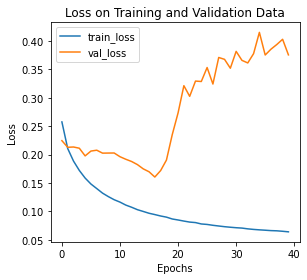

In [19]:
training_vis(train_losses, valid_losses)

In [20]:
# 加载最佳模型权重
checkpoint = torch.load('/WdHeDisk/users/zhangnong/MJO/908_test/cnn_seq2seq_s2s_data_weights.pth')
model = Model()
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [21]:
#测试集300
X1_test_300=X_test
Y_test_300=Y_test

In [22]:
testset = MJODataset(X1_test_300, Y_test_300)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

In [23]:
Y_test_300=t.from_numpy(Y_test_300)

In [24]:
# 在测试集上评估模型效果
model.eval()
model.to(device)
t_scores_rmse=[]
#t_scores_cor=[]
t_s=0
#t_ss=0
t_preds = np.zeros((len(Y_test_300),35,2))
for i, data in tqdm(enumerate(testloader)):
    data1, labels = data
    data1 = data1.to(device)
    labels = labels.to(device)
    t_pred = model(data1)
    #t_pred= t_pred.permute(0,2,1).contiguous()
    t_preds[i*batch_size:(i+1)*batch_size] = t_pred.detach().cpu()
t_preds=torch.as_tensor(t_preds)
#t_s=rmse(Y_test,t_preds)
t_s=rmse_new(Y_test_300,t_preds)
t_ss=cor(Y_test_300,t_preds)
t_scores_rmse.append(t_s)
#t_scores_cor.append(t_ss)
print('Score_rmse: {:.3f}'.format(t_s))
print('Score_cor: {:.3f}'.format(t_ss))

25it [00:00, 91.52it/s]


Score_rmse: 34.000
Score_cor: 34.000


In [25]:
t_preds=t_preds.numpy()
Y_test_300=Y_test_300.numpy()
#绘制30条数据的rmm指数预测区别，预测和真实值预测
def rmm1_vis_30(Y_test,t_preds,index):
    fig = plt.figure(figsize=(8,4))
    ax1 = fig.add_subplot(121)
    ax1.plot(Y_test[index,:,0], label='RMM1:true')
    ax1.plot(t_preds[index,:,0], label='RMM1:pred')
    ax1.set_xlabel('time')
    ax1.set_ylabel('rmm1')
    ax1.set_title('RMM1 on truth and prediction data with time')
    ax1.legend()
    plt.tight_layout()

def rmm2_vis_30(Y_test,t_preds,index):
    fig = plt.figure(figsize=(8,4))
    ax1 = fig.add_subplot(121)
    ax1.plot(Y_test[index,:,1], label='RMM2:true')
    ax1.plot(t_preds[index,:,1], label='RMM2:pred')
    ax1.set_xlabel('time')
    ax1.set_ylabel('rmm2')
    ax1.set_title('RMM2 on truth and prediction data with time')
    ax1.legend()
    plt.tight_layout()

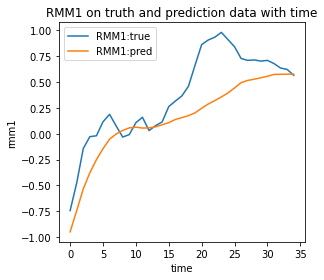

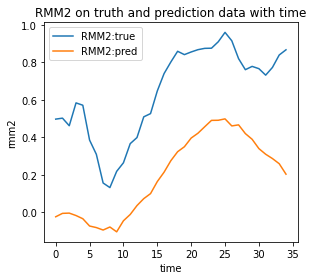

In [26]:
index=33 #可以取0～3200
rmm1_vis_30(Y_test_300,t_preds,index)
rmm2_vis_30(Y_test_300,t_preds,index)

In [27]:
#cor评价指标
def cor_caluate(Y_test,t_preds):
    cor_day = []
    a=0
    b=0
    c=0
    for i in range(0,35):
        for j in range(0,len(Y_test)):
            a+=(Y_test[j,i,:]*t_preds[j,i,:]).sum()
            b+=(Y_test[j,i]**2).sum()
            c+=(t_preds[j,i]**2).sum()
        b=np.sqrt(b)
        c=np.sqrt(c)
        cor=a/(b*c)
        cor_day.append(cor)
        a=0
        b=0
        c=0
    cor_day=np.array(cor_day)
    print(cor_day)
    return cor_day

In [28]:
#画cor指标
def cor_acc(cor_day):
    # 绘制损失函数曲线
    fig = plt.figure(figsize=(8,4))
    # subplot loss
    ax1 = fig.add_subplot(121)
    ax1.plot(cor_day, label='cor_acc')
    ax1.set_xlabel('days')
    ax1.set_ylabel('cor')
    ax1.set_title('MJO Bivariate Correlation')
    ax1.legend()
    ax1.axhline(y=0.5,color='red',linewidth=0.85)
    plt.tight_layout()

[0.9387011  0.90036606 0.85631087 0.81205874 0.76927337 0.72637043
 0.69169281 0.66714196 0.65482588 0.64175908 0.63984592 0.63690252
 0.63120466 0.62987575 0.62440377 0.6193959  0.6101929  0.6026147
 0.59337828 0.58545873 0.57495742 0.5736807  0.56640223 0.56044313
 0.55285683 0.54968376 0.54589028 0.54359477 0.5429883  0.5441016
 0.54308056 0.54619842 0.54444515 0.54574968 0.5397792 ]


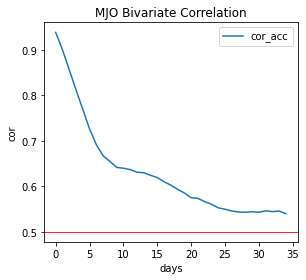

In [29]:
cor_day=cor_caluate(Y_test_300,t_preds)
cor_acc(cor_day)

In [30]:
#rmse评价指标
def rmse_caluate(Y_test,t_preds):
    rmse_day = []
    a=0
    for i in range(0,35):
        for j in range(0,len(Y_test)):
            a+=((Y_test[j,i,:]-t_preds[j,i,:])**2).sum()
        rmse=a/len(Y_test)
        rmse=np.sqrt(rmse)
        rmse_day.append(rmse)
        a=0
    rmse_day=np.array(rmse_day)
    print(rmse_day)
    return rmse_day

In [31]:
#画rmse指标
def rmse_acc(rmse_day):
    # 绘制损失函数曲线
    fig = plt.figure(figsize=(8,4))
    # subplot loss
    ax1 = fig.add_subplot(121)
    ax1.plot(rmse_day, label='rmse_acc')
    ax1.set_xlabel('days')
    ax1.set_ylabel('rmse')
    ax1.set_title('MJO Bivariate Correlation')
    ax1.legend()
    ax1.axhline(y=1.4,color='red',linewidth=0.85)
    plt.tight_layout()

[0.3733969  0.45665231 0.5266966  0.5806469  0.61959624 0.64901054
 0.66381746 0.66700908 0.66242017 0.66031391 0.65262426 0.64730503
 0.64494253 0.64084927 0.64039089 0.6388069  0.63924863 0.63852592
 0.63973988 0.64263891 0.64583875 0.64373098 0.6439746  0.64356723
 0.64453252 0.64226602 0.64064522 0.63847518 0.63407307 0.62835194
 0.62335933 0.61565648 0.61022705 0.60305194 0.59960628]


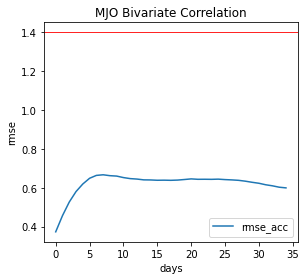

In [32]:
rmse_day=rmse_caluate(Y_test_300,t_preds)
rmse_acc(rmse_day)

In [33]:
#t-preds是预测的，直接和真实rmm比较试试
re_Y_test=np.load(path+'re_Y_test'+wei)

[0.88205036 0.84383302 0.80269419 0.76131021 0.72337264 0.68458656
 0.63888577 0.60011419 0.57684346 0.55620005 0.54902778 0.55474725
 0.55778911 0.55544283 0.54876579 0.5447583  0.53742379 0.52842059
 0.51507726 0.50639261 0.49446597 0.48836449 0.47496394 0.46083622
 0.43651513 0.4204396  0.40459843 0.38215607 0.36129043 0.348329
 0.33781178 0.33416737 0.32142467 0.3211609  0.3166597 ]


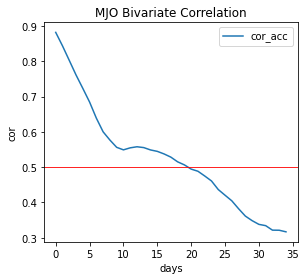

In [34]:
re_cor_day=cor_caluate(re_Y_test,t_preds)
cor_acc(re_cor_day)

[0.61589079 0.70582979 0.7920262  0.87176003 0.92493451 0.96883829
 1.01727169 1.05488191 1.07274686 1.09536588 1.1124553  1.10847635
 1.11391588 1.12557151 1.14286344 1.15548305 1.16997722 1.18755217
 1.19855955 1.20528363 1.21537328 1.2212088  1.23021282 1.24555331
 1.27103522 1.28371232 1.29616589 1.31292804 1.33011969 1.33382241
 1.33820935 1.3429485  1.34962243 1.34939338 1.35182866]


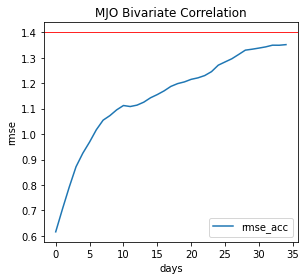

In [35]:
re_rmse_day=rmse_caluate(re_Y_test,t_preds)
rmse_acc(re_rmse_day)

In [36]:
def best_day(cor, rmse):
    best_cor = 0
    best_rmse = 0
    for i in range(len(cor)):
        if cor[i] < 0.5:
            break
    best_cor = i
    
    for j in range(len(rmse)):
        if rmse[j] > 1.4:
            break
    best_rmse = j
    
    print('Score_cor: {:.3f} day'.format(best_cor))
    print('Score_rmse: {:.3f} day'.format(best_rmse))

In [37]:
best_day(re_cor_day, re_rmse_day)

Score_cor: 20.000 day
Score_rmse: 34.000 day
